In [449]:
import os
import sys
import pickle
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto  import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch_scatter import scatter_mean

from torch_geometric.data import DataLoader
from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
from torch_geometric.data import (InMemoryDataset, Data, Dataset)
import torch_geometric.transforms as T
from torch_geometric.utils import normalized_cut
# import torch_spline_conv
from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)
# from torch_geometric.nn import graclus,  max_pool, max_pool_x, global_mean_pool
# from torch_spline_conv import (SplineConv)
# import torch_spline_conv

# from torch_geometric.datasets import MNISTSuperpixels
import keras

import progressbar

In [2]:

X_train = np.load("skel_features/mnist/save/X_train.npy", allow_pickle=True)
X_test = np.load("skel_features/mnist/save/X_test.npy", allow_pickle=True)
y_train = np.load("skel_features/mnist/save/y_train.npy", allow_pickle=True)
y_test = np.load("skel_features/mnist/save/y_test.npy", allow_pickle=True)
skeleton_train = np.load("skel_features/mnist/save/skeleton_train.npy", allow_pickle=True)
skeleton_test = np.load("skel_features/mnist/save/skeleton_test.npy", allow_pickle=True)

num_edges = np.max([x.shape[0] for x in np.hstack([skeleton_train, skeleton_test])])
# num_nodes = np.max([len(xzzzzzz) for x in np.hstack([skeleton_train, skeleton_test])])

# for i in range(len(skeleton_train)):
#     tmp = np.zeros((max_len))
#     tmp[:len(skeleton_train[i])] = skeleton_train[i]
#     skeleton_train[i] = tmp
    
# for i in range(len(skeleton_test)):
#     tmp = np.zeros((max_len))
#     tmp[:len(skeleton_test[i])] = skeleton_test[i]
#     skeleton_test[i] = tmp
    
X_train = np.vstack(X_train).reshape(60000,28,28,1)
X_test = np.vstack(X_test).reshape(10000,28,28,1)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
# skeleton_train = np.vstack(skeleton_train)
# skeleton_test = np.vstack(skeleton_test)


num_nodes = 75

### we need to transform skeleton to edge_index

In [3]:
# bar = progressbar.ProgressBar(skeleton_train.shape[0])
# bar.start()

# edge_index_train = []
# for j, skeleton in enumerate(skeleton_train):
#     skeleton = skeleton.reshape(-1,8)
#     nodes_l = skeleton[:, 0:2]
#     nodes_r = skeleton[:, 4:6]
    
#     nodes = np.unique(np.vstack((nodes_l, nodes_r)), axis=0)
#     node_ind = {}
#     for i, node in enumerate(nodes):
#         node_ind[str(node)] = i

#     edge_index = [[],[]]
#     for i in range(nodes_l.shape[0]):
#         node0 = node_ind[str(nodes_l[i])]
#         node1 = node_ind[str(nodes_r[i])]
#         edge_index[0].append(node0)
#         edge_index[1].append(node1)
    
#     edge_index_train.append(edge_index)
    
#     bar.update(j)
    
    

In [24]:
bar = progressbar.ProgressBar(skeleton_test.shape[0])
bar.start()

edge_index_test = []
node_features_test = []
for j, skeleton in enumerate(skeleton_test):
    skeleton = skeleton.reshape(-1,8)
    nodes_l = skeleton[:, 0:2]
    nodes_r = skeleton[:, 4:6]
    
    nodes = np.unique(np.vstack((nodes_l, nodes_r)), axis=0)
    node_ind = {}
    for i, node in enumerate(nodes):
        node_ind[str(node)] = i

    edge_index = [[],[]]
    for i in range(nodes_l.shape[0]):
        node0 = node_ind[str(nodes_l[i])]
        node1 = node_ind[str(nodes_r[i])]
        edge_index[0].append(node0)
        edge_index[1].append(node1)
    
    edge_index_test.append(edge_index)
    
    node_features = np.zeros(num_nodes)
    for skel in skeleton:
        node0 = str(skel[0:2])
        features0 = skel[3]
        node1 = str(skel[4:6])
        features1 = skel[7]
        
        node_features[node_ind[node0]] = features0
        node_features[node_ind[node1]] = features1
        
    node_features_test.append(node_features)
        
    
    bar.update(j)

In [28]:
data = pd.DataFrame(columns=['edge_index', 'node_features'])
data.edge_index = [torch.tensor(x) for x in edge_index_test]
data.node_features = [torch.tensor(x) for x in node_features_test]
data.to_csv("test_features.csv")

In [46]:
class SkeletonDataset(Dataset):
    def __init__(self, edge_index, node_features, y_test):
        data = []
        for i in range(edge_index.shape[0]):
            data.append(Data(x=torch.tensor(node_features[i]), edge_index=torch.tensor(edge_index[i]), y=y_test[i]))
            
        self.data = data
        self.len = edge_index.shape[0]
        
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return self.len

In [307]:
SD = SkeletonDataset(data.edge_index, data.node_features, y_test)

/Users/aydar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [48]:
SD[0]

Data(edge_index=[2, 39], x=[75], y=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.])

### GNNet

In [478]:
class GNNNet(torch.nn.Module):
    def __init__(self, num_features, num_classes=10):
        super(GNNNet, self).__init__()
        self.conv1 = GraphConv(num_features, 128)
        self.conv2 = GraphConv(128, 128)
        self.conv3 = GraphConv(128, num_features)
        self.fc1 = torch.nn.Linear(num_features, num_features)
        self.fc2 = torch.nn.Linear(num_features, 32)
        self.fc3 = torch.nn.Linear(32, num_classes)
 
    def reset_parameters(self):
        for (name, module) in self._modules.items():
            module.reset_parameters()
 
    def forward(self, data):
        data.x = F.elu(self.conv1(data.x, data.edge_index))
#         print(data.x.shape)
        data.x = F.elu(self.conv2(data.x, data.edge_index))
#         print(data.x.shape)
        data.x = F.elu(self.conv3(data.x, data.edge_index))
        
#         print(data.x.shape)
#         x_1 = scatter_mean(data.x, data.batch, dim=0)
#         x_1 = scatter_mean(data.x, dim=0)
#         x = x_1
        x = data.x
 
        x = F.elu(self.fc1(x))
#         print(x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
#         print(x.shape)
        x = F.elu(self.fc2(x))
#         print(x.shape)
        x = self.fc3(x)
#         print(x.shape)
        return F.log_softmax(x)

In [479]:
def train(model, train_loader, optimizer):
    model.train()
    history = []
    for data in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        response = model(data)
#         print(response.unsqueeze(1).T.size())
#         print(torch.tensor(data.y).size())
    
        F.nll_loss(response.unsqueeze(1).T, torch.tensor([np.argmax(data.y)])).backward()
        history.append(F.nll_loss(response.unsqueeze(1).T, torch.tensor([np.argmax(data.y)])).item())
        optimizer.step()
    
    return np.array(history)

In [480]:
gnn = GNNNet(num_features=num_nodes).double()
train_loader = DataLoader(SD, batch_size=1, shuffle=True)
optimizer = torch.optim.Adam(gnn.parameters())

In [482]:
train_loader.dataset

SkeletonDataset(10000)

In [481]:
h = train(gnn, train_loader, optimizer)

/Users/aydar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [467]:
(np.array(h) > 10).sum()

2

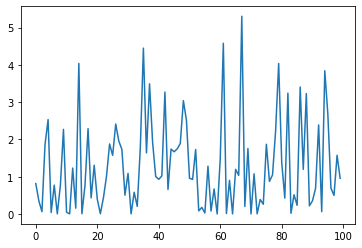

In [469]:
plt.plot(h[-100:])

In [301]:
d = SD[240]
ei = d.edge_index

In [302]:
d.edge_index

tensor([[ 0,  5,  1,  2,  4,  7, 10, 11, 13, 16, 22, 23, 24, 28, 29, 31, 32, 34,
         33, 30, 27, 26, 25, 21, 20, 19, 18, 17, 15, 14, 12,  9,  8,  6,  5],
        [ 3,  3,  0,  1,  2,  4,  7, 10, 11, 13, 16, 22, 23, 24, 28, 29, 31, 32,
         34, 33, 30, 27, 26, 25, 21, 20, 19, 18, 17, 15, 14, 12,  9,  8,  6]])

In [305]:
ind = np.argsort(ei[0])
ei[0] = torch.tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,\
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 0,0,0])
ei[1] = torch.tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,\
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,35,0,0])

In [306]:
gnn.forward(d)

/Users/aydar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([-2.2108, -2.2329, -2.2781, -2.2127, -2.2759, -2.2367, -2.5385, -2.4795,
        -2.4170, -2.2091], dtype=torch.float64, grad_fn=<LogSoftmaxBackward>)

In [222]:
np.arange(39)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [168]:
d.edge_index[:,:32]

tensor([[ 0,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
        [ 0,  1,  7,  5,  0,  8, 13,  3, 10, 11,  6, 14, 18,  9, 15, 17, 20, 12,
         19, 23, 21, 24, 28, 16, 26, 30, 22, 32, 25, 33, 27, 34]])

In [170]:
d.edge_index

tensor([[ 0,  1,  7,  5,  0,  8, 13,  3, 10, 11,  6, 14, 18,  9, 15, 17, 20, 12,
         19, 23, 21, 24, 28, 16, 26, 30, 22, 32, 25, 33, 27, 34, 29, 36, 37,  4,
         31, 38, 35],
        [ 0,  1,  7,  5,  0,  8, 13,  3, 10, 11,  6, 14, 18,  9, 15, 17, 20, 12,
         19, 23, 21, 24, 28, 16, 26, 30, 22, 32, 25, 33, 27, 34, 29, 36, 37,  4,
         31, 38, 35]])

In [153]:

d.edge_index 

UsageError: Cell magic `%%` not found.


In [132]:
d.edge_index

tensor([[0, 1, 2],
        [1, 2, 3]])

In [138]:
d.edge_index

tensor([[1, 0, 2],
        [3, 1, 0]])

In [142]:
d.edge_index

tensor([[22, 20, 18, 17, 19, 15,  8,  7,  6,  5,  3,  1,  0,  2,  4, 14, 13, 12,
         11, 10,  9,  4, 19],
        [23, 22, 20, 18, 18, 17, 15,  8,  7,  6,  5,  3,  1,  0,  2, 16, 14, 13,
         12, 11, 10,  9, 21]])

In [145]:
d.edge_index

tensor([[ 4,  6,  0,  1,  2,  3,  7,  9, 10, 11, 13, 14, 15, 16, 20, 23, 25, 27,
         29, 28, 26, 24, 22, 21, 19, 18, 17, 12,  8,  6],
        [ 5,  5,  4,  0,  1,  2,  3,  7,  9, 10, 11, 13, 14, 15, 16, 20, 23, 25,
         27, 29, 28, 26, 24, 22, 21, 19, 18, 17, 12,  8]])

In [148]:
d.edge_index

tensor([[ 5,  0,  6,  7, 10, 12, 13, 16, 17, 18, 22, 24, 25, 28, 30, 29, 27, 26,
         23, 21, 20, 19, 15, 14, 11,  9,  8,  4,  2,  1,  0],
        [ 3,  3,  5,  6,  7, 10, 12, 13, 16, 17, 18, 22, 24, 25, 28, 30, 29, 27,
         26, 23, 21, 20, 19, 15, 14, 11,  9,  8,  4,  2,  1]])

In [217]:
d.edge_index

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  0,  0,  0,  0,
          0,  0,  0],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 11,  0,  0,  0,
          0,  0,  0]])

In [187]:
gnn.forward(d)

RuntimeError: Invalid index in scatterAdd at /Users/distiller/project/conda/conda-bld/pytorch_1579022061893/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:718
The above operation failed in interpreter.
Traceback (most recent call last):
  File "/Users/aydar/opt/anaconda3/lib/python3.7/site-packages/torch_scatter/scatter.py", line 34
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
               ~~~~~~~~~~~~~~~~ <--- HERE
    else:
        return out.scatter_add_(dim, index, src)


In [5]:
xx = torch.tensor(node_features_test[5000])
tt = torch.tensor(edge_index_test[5000])

D = Data(x=xx, edge_index=tt)

In [45]:
xx = torch.tensor(node_features_test)
# ei = torch.tensor(edge_index_test)
ei = edge_index_test

D = []
for i in range(xx.shape[0]):
    x = xx[i]
    e = torch.tensor(ei[i])
    D.append(Data(x=x, edge_index=e))
    

In [47]:
len(D)

10000

In [31]:
D

Data(edge_index=[2, 20], x=[64])

In [8]:
class MPNNNet(nn.Module):
    def __init__(self, num_features, aggr='mean', processing_steps=8, message_passing_steps=4, dim=65):
        super(MPNNNet, self).__init__()
        self.message_passing_steps = message_passing_steps
        
        self.lin0 = torch.nn.Linear(num_nodes, dim) # Change 2 to 1 for superpixels
        nn = torch.nn.Sequential(torch.nn.Linear(2, 128), torch.nn.ReLU(), torch.nn.Linear(128, dim * dim))
        self.conv = NNConv(dim, dim, nn, aggr=aggr, root_weight=False)
        self.gru = torch.nn.GRU(dim, dim)
        
        self.set2set = Set2Set(dim, processing_steps=processing_steps)
        self.lin1 = torch.nn.Linear(2 * dim, dim)
        self.lin2 = torch.nn.Linear(dim, 10)

    def forward(self, data):
        out = F.relu(self.lin0(data.x))
        h = out.unsqueeze(0)

        for i in range(self.message_passing_steps):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        return F.log_softmax(self.lin2(out), dim=1)

In [66]:
net.forward(D)

AttributeError: 'NoneType' object has no attribute 'dim'

 ### 1 object

In [448]:
xx = torch.tensor(node_features_test[5000])
tt = torch.tensor(edge_index_test[5000])

D = Data(x=xx, edge_index=tt)

In [449]:
D.x.shape

torch.Size([75])

In [450]:
gnn.forward(D)

/Users/aydar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([-2.2811, -2.3473, -2.4252, -2.3794, -2.2717, -2.3948, -2.3254, -2.0849,
        -2.3859, -2.1827], dtype=torch.float64, grad_fn=<LogSoftmaxBackward>)

In [451]:
D.x.shape

torch.Size([75])

In [452]:
gnn.forward(D)

/Users/aydar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([-2.2182, -2.3959, -2.4718, -2.2631, -2.3265, -2.3516, -2.2952, -2.1595,
        -2.4514, -2.1501], dtype=torch.float64, grad_fn=<LogSoftmaxBackward>)

### training

In [469]:
xx = torch.tensor(node_features_test)
# ei = torch.tensor(edge_index_test)
ei = edge_index_test

D = []
for i in range(xx.shape[0]):
    x = xx[i]
    e = torch.tensor(ei[i])
    D.append(Data(x=x, edge_index=e))
    
    
for i in range(len(D)):
    D[i]['y'] = y_test[i]
    
data = pd.DataFrame(columns=['col', 'y'])
data.col=D
data.y = torch.tensor(y_test)

In [470]:
gnn = GNNNet(num_features=num_nodes).double()

In [471]:
# gnn.forward(D)

In [472]:

indices = list(range(len(D)))
np.random.seed(43)
np.random.shuffle(indices)
train_indices = indices[:100]
sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(D, batch_size=1, sampler=sampler, shuffle=False)

In [473]:
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)

In [480]:
gnn.train() 

for dat in train_loader:
    optimizer.zero_grad()
    response = gnn.forward(dat)
    print(response)
    print(torch.tensor(dat.y))
#     print(dat.y.shape)
    print(F.nll_loss(response, torch.tensor(dat.y)))
    F.nll_loss(response, torch.tensor(dat.y)).backward()
    optimizer.step()

tensor([-2.2485, -2.0818, -2.2441, -2.4467, -2.3894, -2.4930, -2.3302, -2.3331,
        -2.5484, -2.0378], dtype=torch.float64, grad_fn=<LogSoftmaxBackward>)
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


/Users/aydar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


ValueError: Expected 2 or more dimensions (got 1)

In [75]:
def train(model, train_loader, optimizer):
    model.train()

    for data in tqdm(train_loader, leave=False):
#         data = data.to(device)
        optimizer.zero_grad()
        responce = model(data)
        F.nll_loss(responce, data.y).backward()
        optimizer.step()
        

In [76]:
train(gnn, train_loader, optimizer)

RuntimeError: size mismatch, m1: [1 x 4800], m2: [75 x 32] at /Users/distiller/project/conda/conda-bld/pytorch_1579022061893/work/aten/src/TH/generic/THTensorMath.cpp:136